Imports

In [483]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import statsmodels.api as sm
from sklearn import linear_model
from kneed import KneeLocator
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression # or mutual_info_regression, if desired
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap, BoundaryNorm
plt.style.use('fivethirtyeight')
%matplotlib inline
df = pd.read_csv('middleSchoolData.csv')
unchanged_df = df
df.head()
len(df.columns)

24

#### Some schools with NaN's in their school sizes did not allow me to properly work with the dataset, so I have to remove them
#### Also, I am not sure what to do with NaN's. I had previously been filling them with 0's but that might result in innacurate tests in the future so I'll make one with filled NaN's and another with them dropped.
#### Dropping df causes a looss of around 150 school rows.


In [484]:
df = df.dropna().reset_index().drop(columns=[ 'index'])

#### Here, I'll be doing Principal Component Analysis on the dataset to get rid of certain redundant columns.

In [485]:
# Scale data first!
l_q = StandardScaler().fit_transform(df.iloc[:, 11:17])
v_x = StandardScaler().fit_transform(df.iloc[:, -3:])
drop_lq = df.columns[12:18]
drop_list = drop_lq.append(df.columns[-3:])
# Since we only want to make one column for each of the columns with chose, we can make a variable to do so with PCA()
pca = PCA(n_components=1)
lq = pca.fit_transform(l_q)
vx = pca.fit_transform(v_x)
# Add the new columns into the original dataset
df['school_climate'] = lq
df['achievement'] = vx
# And drop the former columns since we have the new ones in already!
dropped_df = df.drop(drop_list, axis = 1)
df = df.drop(drop_list, axis = 1)

### 1. What is the correlation between the number of applications and admissions to HSPHS

,applications,acceptances
applications,1.000000,0.805278
acceptances,0.805278,1.000000


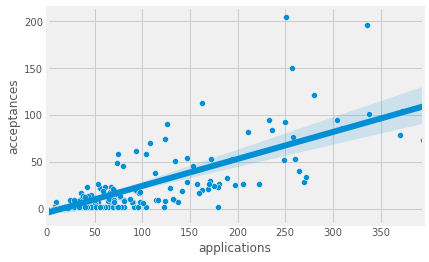

R-Squared: 0.6484718859141051


17

In [486]:
display(df[['applications', 'acceptances']].corr())
sns.regplot(data=df[['applications', 'acceptances']], x='applications', y='acceptances', scatter=False)
sns.scatterplot(data=df[['applications', 'acceptances']], x="applications", y="acceptances")
plt.show()
correlation_matrix = np.corrcoef(df['applications'].values, df['acceptances'].values)
correlation_xy = correlation_matrix[0,1]
print('R-Squared:', correlation_xy**2)
len(df.columns)

### 2. What is a better predictor of admission to HSPHS? Raw number of applications or application *rate*?

Create a new column with application rate (# of applicants / # of students in that school)

,applications,appplication_rate,acceptances
applications,1.000000,0.774239,0.805278
appplication_rate,0.774239,1.000000,0.686555
acceptances,0.805278,0.686555,1.000000


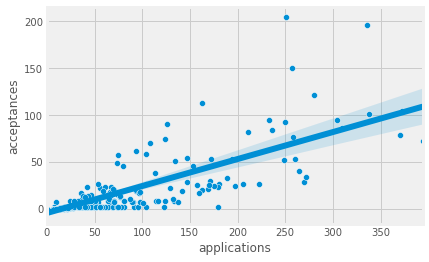

R-Squared: 0.6484718859141051


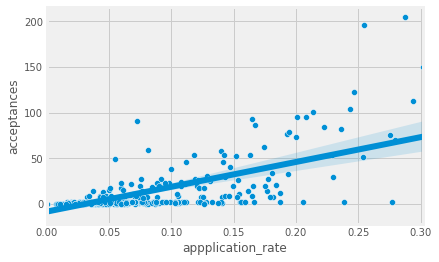

R-Squared: 0.4713576511390133


In [420]:
df['appplication_rate'] = df['applications']/df['school_size'].values
display(df[['applications', 'appplication_rate','acceptances']].corr())
sns.regplot(data=df[['applications', 'acceptances']], x='applications', y='acceptances', scatter=False)
sns.scatterplot(data=df[['applications', 'acceptances']], x="applications", y="acceptances")
plt.show()
correlation_matrix = np.corrcoef(df['applications'].values, df['acceptances'].values)
correlation_xy = correlation_matrix[0,1]
print('R-Squared:', correlation_xy**2)
sns.regplot(data=df[['appplication_rate', 'acceptances']], x='appplication_rate', y='acceptances', scatter=False)
sns.scatterplot(data=df[['appplication_rate', 'acceptances']], x="appplication_rate", y="acceptances")
plt.show()
correlation_matrix = np.corrcoef(df['appplication_rate'].values, df['acceptances'].values)
correlation_xy = correlation_matrix[0,1]
print('R-Squared:', correlation_xy**2)

### 3. Which school has the best *per student* odds of sending someone to HSPHS?

Create a new column with acceptance rate, not by students who applied, but by every student in the school. (# of accepted / # of students in school)

In [472]:
df['acceptance_per_student'] = df['acceptances']/df['school_size']
display(df.sort_values(by='acceptance_per_student', ascending=False)[['school_name', 'acceptance_per_student']].head())

,school_name,acceptance_per_student
274,THE CHRISTA MCAULIFFE SCHOOL\I.S. 187,0.234822
20,NEW YORK CITY LAB MIDDLE SCHOOL FOR COLLABORAT...,0.203971
16,M.S. 255 SALK SCHOOL OF SCIENCE,0.181347
28,J.H.S. 054 BOOKER T. WASHINGTON,0.176056
10,EAST SIDE MIDDLE SCHOOL,0.166667


### 4. Is there a relationship between how students perceive their school (as reported in columns L-Q) and how the school performs on objective measures of achievement (as noted in columns V-X)?

Relationship analysis
Pearson Correlation:


,achievement,school_climate
achievement,1.000000,-0.400255
school_climate,-0.400255,1.000000


Spearman Correlation:


,achievement,school_climate
achievement,1.000000,-0.441473
school_climate,-0.441473,1.000000


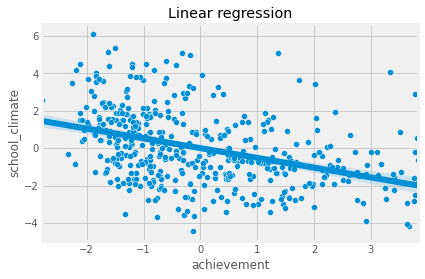

R-Squared: 0.16020399105898336


In [473]:
print("Relationship analysis")
print('Pearson Correlation:')
display(df[['achievement', 'school_climate']].corr())
print('Spearman Correlation:')
display(df[['achievement', 'school_climate']].corr(method='spearman'))
lr = LinearRegression()
lr.fit(df['achievement'].values.reshape(-1,1), df['school_climate'])
plt.title("Linear regression")
sns.regplot(data=df[['achievement', 'school_climate']], x='achievement', y='school_climate', scatter=False)
sns.scatterplot(data=df[['achievement', 'school_climate']], x="achievement", y="school_climate")
plt.show()
correlation_matrix = np.corrcoef(df['achievement'].values, df['school_climate'].values)
correlation_xy = correlation_matrix[0,1]
print('R-Squared:', correlation_xy**2)

### 5. Test a hypothesis of your choice as to which kind of school (e.g. small schools vs. large schools or charter schools vs. not (or any other classification, such as rich vs. poor school)) performs differently than another kind either on some dependent measure, e.g. objective measures of achievement or admission to HSPHS (pick one).

I am hypothesizing that schools below poverty median perform better than ones above the poverty median when it comes to admissions and achievement. 

Null Hypothesis = Rich and poor schools perform the same.

Alternate Hypothesis = Rich schools out-perform poorer ones in both admissions to HSPHS and achievement scores.

In [475]:
applied_schools = df.loc[(df['applications']!=0) & (df['poverty_percent']>0)]
poverty_median = applied_schools['poverty_percent'].median()
df['poverty_percent_median'] = [1 if x > poverty_median else 0 for x in df['poverty_percent'].values]
over_median = df.loc[df['poverty_percent_median']==1] # Larger schools
under_median = df.loc[df['poverty_percent_median']==0] # Smaller schools
print('T-Test to compare achievement scores for schools over and under median poverty_percent:\n', stats.ttest_ind(over_median['achievement'],under_median['achievement']))
print('T-Test to compare acceptances per student for schools over and under median poverty_percent:\n', stats.ttest_ind(over_median['acceptance_per_student'],under_median['acceptance_per_student']))
print('T-Test to compare school climate for schools over and under median poverty_percent:\n', stats.ttest_ind(over_median['school_climate'],under_median['school_climate']))

T-Test to compare achievement scores for schools over and under median poverty_percent:
 Ttest_indResult(statistic=-14.559292296328156, pvalue=1.4048821653500924e-39)
T-Test to compare acceptances per student for schools over and under median poverty_percent:
 Ttest_indResult(statistic=-6.975522259318818, pvalue=1.1031370079181595e-11)
T-Test to compare school climate for schools over and under median poverty_percent:
 Ttest_indResult(statistic=4.166330950246831, pvalue=3.716823943881492e-05)


In [424]:
print(over_median['achievement'].mean(), under_median['achievement'].mean())
print(over_median['acceptance_per_student'].mean(), under_median['acceptance_per_student'].mean())

-0.8061398661443846 0.9012035296048078
0.0028775113839871816 0.01952843521041408


### 6) Is there any evidence that the availability of material resources (e.g. per student spending or class size) impacts objective measures of achievement or admission to HSPHS?

I am hypothesizing that there is a difference between how schools manage resources per student and how those numbers affect achievement and admission scores to HSPHS.

Null Hypothesis = Schools spending more on students perform equally as well as those with less resources per student

Alternate Hypothesis = There is a difference between schools that spend more on students when compared to schools spending less per student than the median.

In [476]:
applied_schools = df.loc[(df['applications']!=0) & (df['per_pupil_spending']>0)]
spending_median = applied_schools['per_pupil_spending'].median()
df['over_spending_median'] = [1 if x > spending_median else 0 for x in df['per_pupil_spending'].values]
over_median = df.loc[df['over_spending_median']==1]
under_median = df.loc[df['over_spending_median']==0]
print('T-Test to compare achievement scores for schools over and under median spending per pupil:\n', stats.ttest_ind(over_median['achievement'],under_median['achievement']))
print('T-Test to compare acceptances per student for schools over and under median spending per pupil:\n', stats.ttest_ind(over_median['acceptance_per_student'],under_median['acceptance_per_student']))
print('T-Test to compare school climate for schools over and under median spending per pupil:\n', stats.ttest_ind(over_median['school_climate'],under_median['school_climate']))

T-Test to compare achievement scores for schools over and under median spending per pupil:
 Ttest_indResult(statistic=-10.765331107735816, pvalue=3.4652961318758566e-24)
T-Test to compare acceptances per student for schools over and under median spending per pupil:
 Ttest_indResult(statistic=-6.653187464301445, pvalue=8.405469631603547e-11)
T-Test to compare school climate for schools over and under median spending per pupil:
 Ttest_indResult(statistic=1.6209979417377685, pvalue=0.10572323108313451)


 We can see that with achievement scores and acceptances per student for schools grouped by median spending per pupil (1=above, 0=below) there is evidence to show significant differences between these two groups.
 
 Null hypotheses are rejected and we cann accept that the Alternate hypothesis is true. In these cases, we can see that schools over the median spending for students have better achievement scores and have higher acceptance rates to HSPHS.
 
 In terms of school climate, there is no statistical differnece between the two group's means. Null Hypothesis for that case means that rich and poor schools have the same school climate in general. 

### 7) What proportion of schools accounts for 90% of all students accepted to HSPHS? 


20.27 % of schools account for at least 90% of students accepted into HSPHS


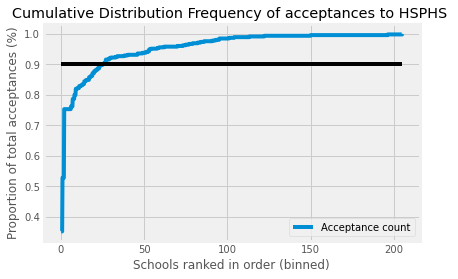

In [477]:
df.sort_values(by='acceptances', ascending=False)
total = 0.9*df['acceptances'].sum()
school_count = 0
sum_acceptances = 0    
while (sum_acceptances <= total):
    for index, row in df.sort_values(by='acceptances', ascending=False).iterrows():
        sum_acceptances += df.iloc[index]['acceptances']
        if sum_acceptances >= total:
            break
        else:
            school_count += 1
print(100*(round(school_count/len(df), 4)), '% of schools account for at least 90% of students accepted into HSPHS')
data = df['acceptances'].sort_values(ascending=False).values
count, bins_count = np.histogram(data, bins=1000)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, label="Acceptance count")
plt.plot([0,205], [.9,.9], color='black')
plt.legend()
plt.gca().set_ylabel('Proportion of total acceptances (%)')
plt.gca().set_xlabel('Schools ranked in order (binned)')
plt.gca().set_title('Cumulative Distribution Frequency of acceptances to HSPHS ')
plt.show()

In [478]:
.2027*len(df)

91.0123

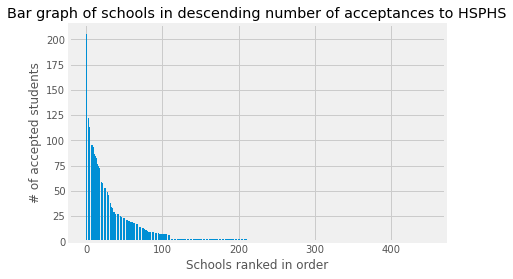

3778

In [427]:
data = df['acceptances'].sort_values(ascending=False).reset_index()
plt.bar(data.index, data['acceptances'].values)
plt.gca().set_ylabel('# of accepted students')
plt.gca().set_xlabel('Schools ranked in order')
plt.gca().set_title('Bar graph of schools in descending number of acceptances to HSPHS')
plt.show()
df.sort_values('acceptances', ascending=False).iloc[:school_count+1]['acceptances'].sum()

### 8) Build a model of your choice – clustering, classification or prediction – that includes all factors – as to what school characteristics are most important in terms of a) sending students to HSPHS, b) achieving high scores on objective measures of achievement?

In [459]:
feature_names = df.columns[2:-5].append(df.columns[-4:])
feature_names

Index(['applications', 'acceptances', 'per_pupil_spending', 'avg_class_size',
       'asian_percent', 'black_percent', 'hispanic_percent',
       'multiple_percent', 'white_percent', 'rigorous_instruction',
       'poverty_percent', 'ESL_percent', 'school_size', 'school_climate',
       'appplication_rate', 'acceptance_per_student', 'poverty_percent_median',
       'over_spending_median'],
      dtype='object')

In [460]:
X = df[feature_names]
y = df['achievement']
regr = linear_model.LinearRegression()
regr.fit(X, y)
r_sq = regr.score(X, y)

In [461]:
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            achievement   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     78.03
Date:                Mon, 17 May 2021   Prob (F-statistic):          5.51e-123
Time:                        12:26:48   Log-Likelihood:                -494.31
No. Observations:                 449   AIC:                             1027.
Df Residuals:                     430   BIC:                             1105.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      9.9062     53.744      0.184      0.854     -95.728     115.540
applications              -0.0031      0.002     -1.386      0.167      -0.007       0.001
acceptances                0.0070      0.006      1.196      0.233      -0.005       0.019
per_pupil_spending     -2.506e-05   1.38e-05     -1.812      0.071   -5.22e-05    2.12e-06
avg_class_size             0.0155      0.010      1.620      0.106      -0.003       0.034
asian_percent             -0.0696      0.537     -0.130      0.897      -1.126       0.987
black_percent             -0.0987      0.537     -0.184      0.854      -1.154       0.957
hispanic_percent          -0.0894      0.537     -0.167      0.868      -1.145       0.966
multiple_percent          -0.0677      0.537     -0.126      0.900      -1.123       0.988
white_percent             -0.0829      0.537     -0.154      0.877      -1.138       0.973
rigorous_instruction       0.2647      0.091      2.919      0.004       0.086       0.443
poverty_percent           -0.0237      0.005     -5.018      0.000      -0.033      -0.014
ESL_percent               -0.0149      0.004     -3.546      0.000      -0.023      -0.007
school_size                0.0002      0.000      0.712      0.477      -0.000       0.001
school_climate            -0.0960      0.030     -3.252      0.001      -0.154      -0.038
appplication_rate          3.4285      1.646      2.083      0.038       0.193       6.664
acceptance_per_student    -1.6706      4.641     -0.360      0.719     -10.792       7.450
poverty_percent_median     0.0418      0.113      0.372      0.710      -0.179       0.263
over_spending_median      -0.1235      0.110     -1.124      0.262      -0.339       0.092
==============================================================================
Omnibus:                      114.046   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              415.118
Skew:                           1.110   Prob(JB):                     7.22e-91
Kurtosis:                       7.154   Cond. No.                     3.23e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.23e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We can see that there are 5 significant vectors (P-Value below 0.05) attributing to achievement scores. These are rigorous_instruction, poverty_percent, ESL_percent, school_climate, and application_rate. Application rate can be dismissed given that it's a column created by dividing two other columns. 

In [462]:
feature_names = ['rigorous_instruction', 'poverty_percent', 'ESL_percent', 'school_climate']
X = df[feature_names]
y = df['achievement']
regr = linear_model.LinearRegression()
regr.fit(X, y)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            achievement   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     178.4
Date:                Mon, 17 May 2021   Prob (F-statistic):           5.70e-91
Time:                        12:26:49   Log-Likelihood:                -604.89
No. Observations:                 449   AIC:                             1220.
Df Residuals:                     444   BIC:                             1240.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.2384      0.478      2.593      0.010       0.300       2.177
rigorous_instruction     0.6506      0.108      6.020      0.000       0.438       0.863
poverty_percent         -0.0468      0.003    -17.871      0.000      -0.052      -0.042
ESL_percent              0.0004      0.004      0.084      0.933      -0.008       0.009
school_climate          -0.0321      0.035     -0.912      0.362      -0.101       0.037
==============================================================================
Omnibus:                       40.708   Durbin-Watson:                   1.588
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.135
Skew:                           0.708   Prob(JB):                     4.77e-12
Kurtosis:                       3.885   Cond. No.                         898.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [463]:
feature_names = list(df.columns[2:-5].append(df.columns[-4:]))
feature_names.remove('acceptances')
feature_names
X = df[feature_names]
y = df['acceptances']
regr = linear_model.LinearRegression()
regr.fit(X, y)
r_sq = regr.score(X, y)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            acceptances   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     384.7
Date:                Mon, 17 May 2021   Prob (F-statistic):          5.05e-248
Time:                        12:26:49   Log-Likelihood:                -1438.2
No. Observations:                 449   AIC:                             2912.
Df Residuals:                     431   BIC:                             2986.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    681.0039    438.153      1.554      0.121    -180.179    1542.187
applications               0.2649      0.013     20.621      0.000       0.240       0.290
per_pupil_spending     -7.268e-05      0.000     -0.643      0.520      -0.000       0.000
avg_class_size             0.0832      0.078      1.063      0.288      -0.071       0.237
asian_percent             -6.7968      4.381     -1.552      0.122     -15.407       1.813
black_percent             -6.7998      4.378     -1.553      0.121     -15.405       1.805
hispanic_percent          -6.8205      4.378     -1.558      0.120     -15.426       1.785
multiple_percent          -6.8644      4.378     -1.568      0.118     -15.468       1.740
white_percent             -6.7881      4.378     -1.550      0.122     -15.394       1.817
rigorous_instruction      -0.3815      0.741     -0.515      0.607      -1.838       1.075
poverty_percent            0.0703      0.038      1.830      0.068      -0.005       0.146
ESL_percent               -0.0459      0.034     -1.344      0.180      -0.113       0.021
school_size               -0.0080      0.002     -4.731      0.000      -0.011      -0.005
school_climate            -0.2558      0.241     -1.061      0.289      -0.730       0.218
appplication_rate       -157.3310     11.123    -14.145      0.000    -179.193    -135.469
acceptance_per_student   693.7745     17.960     38.629      0.000     658.474     729.075
poverty_percent_median    -0.7177      0.919     -0.781      0.435      -2.524       1.089
over_spending_median       1.9184      0.893      2.148      0.032       0.163       3.674
==============================================================================
Omnibus:                      233.012   Durbin-Watson:                   2.126
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11129.982
Skew:                           1.473   Prob(JB):                         0.00
Kurtosis:                      27.212   Cond. No.                     3.22e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.22e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We can see that in terms of acceptances into HSPHS, there are 5 significant factors, these include applications, school_size, application_rate,acceptance_per_student, and over_spending_median. Of course, application_rate and acceptances_per_student don't really matter in this case because their products of other columns. Let's see the results of doing OLS using the significant factors other than the two previously mentioned.

In [466]:
feature_names = ['school_size', 'applications', 'over_spending_median']
X = df[feature_names]
y = df['acceptances']
regr = linear_model.LinearRegression()
regr.fit(X, y)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            acceptances   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     302.1
Date:                Mon, 17 May 2021   Prob (F-statistic):          6.34e-107
Time:                        12:33:51   Log-Likelihood:                -1813.7
No. Observations:                 449   AIC:                             3635.
Df Residuals:                     445   BIC:                             3652.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    3.4053      1.994      1.708      0.088      -0.514       7.324
school_size             -0.0141      0.003     -5.454      0.000      -0.019      -0.009
applications             0.3382      0.014     24.317      0.000       0.311       0.366
over_spending_median    -2.3905      1.568     -1.525      0.128      -5.472       0.691
==============================================================================
Omnibus:                      373.247   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13931.885
Skew:                           3.256   Prob(JB):                         0.00
Kurtosis:                      29.501   Cond. No.                     2.71e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [467]:
feature_names = list(df.columns[2:-5].append(df.columns[-4:]))
feature_names.remove('acceptance_per_student')
feature_names
X = df[feature_names]
y = df['acceptance_per_student']
regr = linear_model.LinearRegression()
regr.fit(X, y)
r_sq = regr.score(X, y)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     acceptance_per_student   R-squared:                       0.919
Model:                                OLS   Adj. R-squared:                  0.916
Method:                     Least Squares   F-statistic:                     286.8
Date:                    Mon, 17 May 2021   Prob (F-statistic):          1.49e-222
Time:                            12:35:13   Log-Likelihood:                 1556.2
No. Observations:                     449   AIC:                            -3076.
Df Residuals:                         431   BIC:                            -3002.
Df Model:                              17                                         
Covariance Type:                nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -1.0569      0.556     -1.902      0.058      -2.149       0.035
applications              -0.0003   1.91e-05    -13.802      0.000      -0.000      -0.000
acceptances                0.0011    2.9e-05     38.629      0.000       0.001       0.001
per_pupil_spending       1.41e-08   1.44e-07      0.098      0.922   -2.68e-07    2.96e-07
avg_class_size         -5.944e-05   9.94e-05     -0.598      0.550      -0.000       0.000
asian_percent              0.0107      0.006      1.929      0.054      -0.000       0.022
black_percent              0.0107      0.006      1.920      0.055      -0.000       0.022
hispanic_percent           0.0107      0.006      1.926      0.055      -0.000       0.022
multiple_percent           0.0109      0.006      1.960      0.051   -2.96e-05       0.022
white_percent              0.0106      0.006      1.917      0.056      -0.000       0.022
rigorous_instruction       0.0001      0.001      0.151      0.880      -0.002       0.002
poverty_percent           -0.0002    4.8e-05     -4.250      0.000      -0.000      -0.000
ESL_percent              6.32e-05   4.34e-05      1.457      0.146    -2.2e-05       0.000
school_size             5.164e-06   2.19e-06      2.359      0.019    8.62e-07    9.47e-06
school_climate             0.0002      0.000      0.605      0.546      -0.000       0.001
appplication_rate          0.2074      0.014     14.958      0.000       0.180       0.235
poverty_percent_median     0.0029      0.001      2.497      0.013       0.001       0.005
over_spending_median      -0.0023      0.001     -2.069      0.039      -0.005      -0.000
==============================================================================
Omnibus:                      247.430   Durbin-Watson:                   2.156
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11919.115
Skew:                           1.623   Prob(JB):                         0.00
Kurtosis:                      28.031   Cond. No.                     3.22e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.22e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Finally, in terms of acceptances_per_student, we can see that there are 7 significant columns, 4 of which don't carry any information on application numbers, unlike applications and acceptances, which we can ignore. However, if our alpha levels were a bit higher for the cutoff (ie. 0.1 instead of 0.05), we would have 12 significant columns! These including the various columns regarding race, signifying a statistical difference between the acceptance chances for students of different races.

In [479]:
df.corr()

,applications,acceptances,per_pupil_spending,avg_class_size,asian_percent,black_percent,hispanic_percent,multiple_percent,white_percent,rigorous_instruction,poverty_percent,ESL_percent,school_size,school_climate,achievement,appplication_rate,acceptance_per_student,poverty_percent_median,over_spending_median
applications,1.000000,0.805278,-0.409205,0.392699,0.577808,-0.345739,-0.252046,0.065038,0.334859,0.236706,-0.327546,-0.132218,0.712516,-0.072893,0.495781,0.774239,0.617420,-0.328615,-0.438234
acceptances,0.805278,1.000000,-0.342782,0.356322,0.526372,-0.313779,-0.299009,0.187630,0.384032,0.240190,-0.433044,-0.177707,0.473266,-0.115333,0.540852,0.686555,0.893922,-0.316973,-0.339398
per_pupil_spending,-0.409205,-0.342782,1.000000,-0.461250,-0.372722,0.203965,0.220052,-0.126934,-0.258132,-0.232731,0.343736,0.236423,-0.532469,0.119854,-0.460276,-0.266884,-0.295218,0.357809,0.710741
avg_class_size,0.392699,0.356322,-0.461250,1.000000,0.345016,-0.387557,-0.108020,0.073699,0.397643,0.313462,-0.412562,-0.129627,0.448548,-0.212221,0.516258,0.366780,0.352867,-0.342785,-0.391012
asian_percent,0.577808,0.526372,-0.372722,0.345016,1.000000,-0.419171,-0.376441,0.177664,0.226568,0.216158,-0.271920,-0.028493,0.499443,-0.039600,0.533861,0.464277,0.460141,-0.320018,-0.419489
black_percent,-0.345739,-0.313779,0.203965,-0.387557,-0.419171,1.000000,-0.431994,0.008967,-0.469331,-0.262817,0.300404,-0.298629,-0.398306,0.173344,-0.470112,-0.219929,-0.287289,0.167084,0.205397
hispanic_percent,-0.252046,-0.299009,0.220052,-0.108020,-0.376441,-0.431994,1.000000,-0.403732,-0.395112,-0.096342,0.489426,0.559324,-0.149688,0.029879,-0.348971,-0.290152,-0.309097,0.457304,0.241469
multiple_percent,0.065038,0.187630,-0.126934,0.073699,0.177664,0.008967,-0.403732,1.000000,0.265463,0.134605,-0.506991,-0.346892,0.025422,-0.026396,0.349896,0.129538,0.274347,-0.355657,-0.180567
white_percent,0.334859,0.384032,-0.258132,0.397643,0.226568,-0.469331,-0.395112,0.265463,1.000000,0.306612,-0.815881,-0.283950,0.341514,-0.254506,0.652382,0.298370,0.407150,-0.554738,-0.241669
rigorous_instruction,0.236706,0.240190,-0.232731,0.313462,0.216158,-0.262817,-0.096342,0.134605,0.306612,1.000000,-0.331556,-0.172625,0.184718,-0.766220,0.522674,0.272707,0.256923,-0.284788,-0.198622
